# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from tensorboard.plugins import projector

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Generating Shakespearean Text Using a Character RNN (Char-RNN)

### Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5 ## {} -> dataset & [] -> tensor
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15)) # {0, 1, 2, ... 14}
dataset = dataset.window(n_steps, shift=2, drop_remainder=True) # {{0, 1, 2, 3, 4}, {2, 3, 4, 5, 6}, ... }
# flatten and group in batches of size n_steps (fix the size) 
dataset = dataset.flat_map(lambda window: window.batch(n_steps)) # {[0, 1, 2, 3, 4], [2, 3, 4, 5, 6], ... }
# split them into inputs (the first 4 steps) and targets (the last 4 steps)
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:])) # e.g., { [[2,3,4,5], [3,4,5,6]], ...}
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [3]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

We must encode every character as an integer. It will be simpoler to use `Keras's Tokenizer` class. First we need to fit a tokenizer to the text: it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters (it does not start at 0, so we can use that value for masking"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

Now the tokenizer can encode a sentence (or a list of sentence) to a list of character IDs and back.

In [7]:
tokenizer.texts_to_sequences(["First", "come"])

[[20, 6, 9, 8, 3], [19, 4, 15, 2]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3], [19, 4, 15, 2]])

['f i r s t', 'c o m e']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [10]:
max_id, dataset_size

(39, 1115394)

Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [11]:
np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

array([[19,  5,  8, ..., 20, 26, 10]])

In [12]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

Before we continue, we need to split the dataset into a training set, a validation set, and a test set.

> ### How to split a Sequential Dataset
>
> It is very important to avoid any overlap between the training set, the validation set, and the test set. For example, we can take the first 90% of the text for the training set, then the next 5% for the validation set, and the final 5% for the test set. It would also be a good idea to leave a gap between these sets to avoid the risk of a paragraph overlapping over two sets.
When dealing with time series, you would in general split across time,: for example, you might take the years 2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set. However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on.
>
>it is often safer to split across time—but this implicitly assumes that the patterns the RNN can learn in the past (in the training set) will still exist in the future. In other words, we assume that the time series is stationary (at least in a wide sense). For many time series this assumption is reasonable (e.g., chemical reactions should be fine, since the laws of chemistry don’t change every day), but for many others it is not (e.g., financial markets are notoriously not stationary since patterns disappear as soon as traders spot them and start exploiting them). To make sure the time series is indeed sufficiently stationary, you can plot the model’s errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough, and you might be better off training the model on a shorter time span.
>
> In short, splitting a time series into a training set, a validation set, and a test set is not a trivial task, and how it’s done will depend strongly on the task at hand.

Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:

In [13]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [14]:
train_size

1003854

We will use the dataset’s window() method to convert this long sequence of characters into many smaller windows of text. Every instance in the dataset will be a fairly short substring of the whole text, and the RNN will be unrolled only over the length of these substrings. This is called `truncated backpropagation through time`.

By default, the window() method creates nonoverlapping windows, but to get the largest possible training set we use shift=1 so that the first window contains characters 0 to 100, the second contains characters 1 to 101, and so on. To ensure that all windows are exactly 101 characters long (which will allow us to create batches without having to do any padding), we set drop_remainder=True (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character).

In [15]:
# use dataset’s window() method to convert this long sequence of characters into many smaller windows of text
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True) # {{0, 1, ..., 100}, {1, 2, ..., 101}, ...}

__The window() method creates a dataset that contains windows, each of which is also represented as a `dataset`__. It’s a nested dataset, analogous to a list of lists. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, __we cannot use a nested dataset directly__ for training, as our model will expect tensors as input, not datasets. So, __we must call the flat_map() method: it converts a nested dataset into a flat dataset__ (one that does not contain datasets).


In [16]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

Since Gradient Descent works best when the instances in the training set are independent and identically distributed (see Chapter 4), we need to shuffle these windows. Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Below figure summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32)

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/Figure16-1.png?raw=true" alt="Figure 16-1" width=700>

Categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. Here, we will encode each character using a one-hot vector because there are fairly few distinct characters (only 39):

In [19]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

Finally, we just need to add prefetching:

In [20]:
dataset = dataset.prefetch(1)

In [21]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


That’s it! Preparing the dataset was the hardest part. Now let’s create the model.

## Creating and Training the Model

To predict the next character based on the previous 100 characters, we can use an RNN with 2 GRU layers of 128 units each and 20% dropout on both the inputs (dropout) and the hidden states (recurrent_dropout). We can tweak these hyperparameters later, if needed. The output layer is a time-distributed Dense layer. This time this layer must have 39 units (max_id) because there are 39 distinct characters in the text, and we want to output a probability for each possible character (at each time step).

In [22]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 5969s 190ms/step - loss: 1.4628
Epoch 2/10
31370/31370 [==============================] - 5533s 176ms/step - loss: 1.3577
Epoch 3/10
31370/31370 [==============================] - 5555s 177ms/step - loss: 1.3377
Epoch 4/10
31370/31370 [==============================] - 5583s 178ms/step - loss: 1.3283
Epoch 5/10
31370/31370 [==============================] - 5619s 179ms/step - loss: 1.3216
Epoch 6/10
31370/31370 [==============================] - 5800s 185ms/step - loss: 1.3171
Epoch 7/10
31370/31370 [==============================] - 14045s 448ms/step - loss: 1.3139
Epoch 8/10
31370/31370 [==============================] - 83030s 3s/step - loss: 1.3114
Epoch 9/10
31370/31370 [==============================] - 7477s 238ms/step - loss: 1.3095
Epoch 10/10
31370/31370 [==============================] - 6812s 217ms/step - loss: 1.3081


## Using the Model to Generate Text
Now we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let’s create a little function for this:

In [23]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, depth=max_id)

Now let’s use the model to predict the next letter in some text:

In [24]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'u'

### Generating Fake Shakespearean Text
We can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow’s `tf.random.categorical()` function. This will generate more diverse and interesting text. The categorical() function samples random class indices, given the class log probabilities (logits). To have more control over the diversity of the generated text, we can divide the logits by a number called the temperature, which we can tweak as we wish: *a temperature close to 0 will favor the high-probability characters, while a very high temperature will give all characters an equal probability*. The following `next_char()` function uses this approach to pick the next character to add to the input text:

In [25]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [26]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :] # (1, length_of_text, max_id)
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [27]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

Next, we can write a small function that will repeatedly call next_char() to get the next character and append it to the given text:

In [28]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

We are now ready to generate some text! Let’s try with different temperatures:

In [29]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the belly the great of the countryman
that we are t


In [30]:
print(complete_text("t", temperature=1))

this very cisancla?

biondello:
for what the great 


In [31]:
print(complete_text("t", temperature=2))

th no cut!

all:win cone,
reverey.

thids, bid sca:


Apparently our Shakespeare model works best at a temperature close to 1. To generate more convincing text, you could try using more GRU layers and more neurons per layer, train for longer, and add some regularization (for example, you could set recurrent_dropout=0.3 in the GRU layers). Moreover, the model is currently incapable of learning patterns longer than n_steps, which is just 100 characters. You could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences. Alternatively, you could use a stateful RNN.

## Stateful RNN

Until now, we have used only stateless RNNs: at each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away, as it is not needed anymore. **What if we told the RNN to preserve this final state after processing one training batch and use it as the initial state for the next training batch? This way the model can learn long-term patterns despite only backpropagating through short sequences. This is called a stateful RNN.** Let’s see how to build one.

In [32]:
tf.random.set_seed(42)

First, note that a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off. So the first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequence

In [33]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True) # non-overlapping
dataset = dataset.flat_map(lambda window: window.batch(window_length)) # window_length = n_steps + 1
dataset = dataset.repeat().batch(1)# we do not shuffle
"""
if we were to call batch(32), then 32 consecutive windows would be put in the same batch, 
and the following batch would not continue each of these window where it left off. 
The simplest solution to this problem is to just use “batches” containing a single window
"""
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

This figure summarizes the first step:

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure16_2.png?raw=true" alt="Figure 16-2" width=700>



Batching is harder, but it is not impossible:

In [34]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size) # split into 32 texts of equal length
datasets = []

for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part) # fetch the encoded_part
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True) # make windows
    dataset = dataset.flat_map(lambda window: window.batch(window_length)) # into tensors
    datasets.append(dataset)
# batch-fy
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
# split into X & Y
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
# features into one-hot vectors
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [35]:
encoded_parts

[array([19,  5,  8, ..., 19,  4, 11]),
 array([ 7,  1, 31, ..., 10,  7,  5]),
 array([18,  5,  9, ...,  0, 19,  3]),
 array([ 8,  0, 16, ..., 12,  1,  0]),
 array([ 6,  5, 14, ...,  0, 22, 11]),
 array([13, 18, 24, ...,  0,  6,  1]),
 array([ 8,  0, 18, ...,  5, 20,  6]),
 array([ 2, 17,  0, ..., 19,  1, 16]),
 array([17, 10, 27, ...,  0, 25,  5]),
 array([18,  2,  3, ...,  3,  2, 28]),
 array([10,  3, 13, ...,  2,  1,  0]),
 array([ 3, 19,  0, ..., 12,  5, 25]),
 array([ 3,  8, 18, ...,  0,  2,  3]),
 array([ 0, 21,  1, ...,  9,  1,  7]),
 array([ 7, 17,  0, ...,  4,  0, 14]),
 array([ 3,  9,  2, ...,  1, 11, 11]),
 array([28, 10,  2, ..., 24,  0,  2]),
 array([ 6,  1,  0, ...,  3,  8, 20]),
 array([ 1, 12,  0, ...,  0, 21, 13]),
 array([ 2, 17,  0, ...,  0, 19,  4]),
 array([ 2,  6,  1, ..., 13, 14, 21]),
 array([11,  1,  0, ...,  0,  9,  3]),
 array([ 0, 12,  3, ...,  0, 22, 11]),
 array([ 4,  9,  1, ..., 11, 11,  0]),
 array([24,  9,  1, ...,  3, 13,  8]),
 array([ 0, 20, 13, ..., 

> The stateful RNN needs to know the batch size (since it will preserve a state for each input sequence in the batch), so we must set the batch_input_shape argument in the first layer. Note that we can leave the second dimension unspecified, since the inputs could have any length:

In [36]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True, # make sure to set 'stateful' at True
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]), # notice: batch_input_shape 
    keras.layers.GRU(128, return_sequences=True, stateful=True,     # --> take bache of the SAME size as input
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

At the end of each epoch, we need to reset the state before we go back to the beginning of the text. For this we use a small callback:

In [37]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [38]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                   callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 37s 118ms/step - loss: 2.6132
Epoch 2/50
313/313 [==============================] - 37s 118ms/step - loss: 2.1790
Epoch 3/50
313/313 [==============================] - 37s 120ms/step - loss: 2.5259
Epoch 4/50
313/313 [==============================] - 38s 120ms/step - loss: 2.0371
Epoch 5/50
313/313 [==============================] - 38s 121ms/step - loss: 2.1692
Epoch 6/50
313/313 [==============================] - 39s 123ms/step - loss: 1.9915
Epoch 7/50
313/313 [==============================] - 39s 124ms/step - loss: 2.0328
Epoch 8/50
313/313 [==============================] - 39s 123ms/step - loss: 2.0067
Epoch 9/50
313/313 [==============================] - 39s 124ms/step - loss: 1.8919
Epoch 10/50
313/313 [==============================] - 38s 123ms/step - loss: 1.9364
Epoch 11/50
313/313 [==============================] - 39s 123ms/step - loss: 1.8404
Epoch 12/50
313/313 [==============================] - 39s 123ms/step - lo

> After this model is trained, **it will only be possible to use it to make predictions for batches of the same size as were used during training.** 
To use the model with different batch sizes (to avoid this restriction), we need to create a `stateless copy`. We can get rid of dropout since it is only used during training:

In [39]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]), # no stateful
    keras.layers.GRU(128, return_sequences=True),  # input_shape instead of batch_input_shape
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [40]:
# remove the "same batch size" restriction
# we are feeding this shape info because stateful rnn has
# specific shape of [batch_shape, None, max_id]
# So, we change 'batch_shape' to None
stateless_model.build(tf.TensorShape([None, None, max_id]))


Now, the architecture is same. Let us copy the weight off stateful model

In [41]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [42]:
tf.random.set_seed(42)

print(complete_text("t"))

ting, my well whice
stands horse. day note:
when i 


# Sentiment Analysis
Now that we have built a character-level model, it’s time to look at word-level models and tackle a common natural language processing task: sentiment analysis. In the process we will learn how to handle sequences of variable lengths using masking.

In [43]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [44]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

In [45]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

If you want to visualize a review, you can decode it like this:

In [46]:
# Retrieves a dict mapping words to their index in the IMDB dataset.
word_index = keras.datasets.imdb.get_word_index()
# move all indexes by 3 because first 0, 1, 2 have special meaning: 
# padding token, start-of-sequence token, and unknown words
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
# putting special keys 
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token

# try printing
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

Let’s load the original IMDb reviews, as text (byte strings), using TensorFlow Datasets

In [47]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [48]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [49]:
info.description

'Large Movie Review Dataset.\nThis is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.'

In [50]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [51]:
train_size, test_size

(25000, 25000)

In [52]:
datasets["train"]

<_OptionsDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [53]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in ...
Label: 1 = Positive

Review: Oh yeah! Jenna Jameson did it again! Yeah Baby! This movie rocks. It was one of the 1st movies i saw of her. And i have to say i feel in love with her, she was great in this move.<br /><br />Her perfo ...
Label: 1 = Positive



`preprocess` starts by truncating the reviews, keeping only the first 300 characters of each: this will speed up training, and it won't impact performance too much because you can generally tell whether a review is positive or not in the first sentence or two. Then it uses *regular expressions* to replace $<$br /$>$ tags with spaces, and to replace any characters other than letters and quotes with spaces. For example, the text "Well, I can't$<$br /$>$" will become "Well I can't". Finally, the `preprocess()` function splits the reviews by the spaces, which returns a ragged tensor, and it converts this ragged tensor to a dense tensor, padding all review with the padding token "$<$pad$>$" so they all have the same length.

In [54]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300) # first 300 characters
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ") # rb: read binary
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ") # take out non-letters
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch # pad so they all have the same length

Next, we need to construct the vocabulary. This requires going through the whole training set once, applying our preprocess() function, and using a Counter to count the number of occurrences of each word:

In [55]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 60), dtype=string, numpy=
 array([[b'As', b'a', b'lifelong', b'fan', b'of', b'Dickens', b'I',
         b'have', b'invariably', b'been', b'disappointed', b'by',
         b'adaptations', b'of', b'his', b'novels', b'Although', b'his',
         b'works', b'presented', b'an', b'extremely', b'accurate', b're',
         b'telling', b'of', b'human', b'life', b'at', b'every', b'level',
         b'in', b'Victorian', b'Britain', b'throughout', b'them', b'all',
         b'was', b'a', b'pervasive', b'thread', b'of', b'humour', b'that',
         b'could', b'be', b'both', b'playful', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
        [b'Oh', b'yeah', b'Jenna', b'Jameson', b'did', b'it', b'again',
         b'Yeah', b'Baby', b'This', b'movie', b'rocks', b'It', b'was',
         b'one', b'of', b'the', b'st', b'movies', b'i', b'saw', b'of',
         b'her', b'And', b'i', b'have', b'to', b

In [56]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [57]:
vocabulary.most_common()[:3]

[(b'<pad>', 214869), (b'the', 61137), (b'a', 38564)]

In [58]:
len(vocabulary)

53893

Great! We probably don't need our model to know all the words in the dictionary to get good performance, though, so let's truncate the vocabulary, keeping only the 10,000 most common words:

In [59]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [60]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word, vocab_size)) 

22
12
11
10000


Now we need to add a preprocessing step to replace each word with its ID (i.e., its index in the vocabulary). We will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets:

In [61]:
tf.constant(truncated_vocabulary)

<tf.Tensor: shape=(10000,), dtype=string, numpy=
array([b'<pad>', b'the', b'a', ..., b"Woo's", b'attributes', b'muster'],
      dtype=object)>

In [62]:
words = tf.constant(truncated_vocabulary) # [b'<pad>', b'the', b'a', ..., b'gigantic', b'attributes', b'muster']
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64) # 10000
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids) # key - value translator
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [63]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

Note that the word "faaaaaantastic" was not found, so it was mapped to one of the oov buckets, with an ID greater than or equal to 10,000

Now we are ready to create the final training set. We batch the reviews, then convert them to short sequences of words using the `preprocess()` function, then encode these words using a simple `encode_words()` function that uses the table we just built, and finally prefatch the next batch:

In [64]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [65]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  185     2 10865 ...     0     0     0]
 [  718  2409  5629 ...     0     0     0]
 [    6    98     9 ...     0     0     0]
 ...
 [  135     7    73 ...     0     0     0]
 [   22    12     7 ...     0     0     0]
 [10716   438   945 ...     0     0     0]], shape=(32, 66), dtype=int64)
tf.Tensor([1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0], shape=(32,), dtype=int64)


at last we can create the model and train it:

The first layer is `Embedding` layer, which will convert word IDs into embeddings. The embedding matrix needs to have one row per word ID (vocab_size + num_oov_buckets) and one column per embedding dimension(this example uses 128 dimensions, but this is **a hyperparameter you could tune**). Whereas the inputs of the model will be 2D tensors of shape **[batch size, time steps]**, the output of the `Embedding` layer will be a 3D tensor of shape **[batch size, time steps, embeding size]**

In [66]:
from datetime import datetime

log_dir = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, profile_batch=10)

In [67]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, 
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5,
                    callbacks=[tensorboard_cb])

Epoch 1/5
781/781 [==============================] - 69s 88ms/step - loss: 0.5496 - accuracy: 0.7134
Epoch 2/5
781/781 [==============================] - 69s 89ms/step - loss: 0.3570 - accuracy: 0.8517
Epoch 3/5
781/781 [==============================] - 69s 89ms/step - loss: 0.1987 - accuracy: 0.9283
Epoch 4/5
781/781 [==============================] - 69s 89ms/step - loss: 0.1341 - accuracy: 0.9527
Epoch 5/5
781/781 [==============================] - 69s 89ms/step - loss: 0.0904 - accuracy: 0.9681


In [68]:
# %load_ext tensorboard
# %tensorboard --logdir=./my_logs --port=6006

> ## Masking
The model will need to learn that the padding tokens should be ignored. But we already know that! Why don't we tell the model to ignore the paddign tokens, so that it can focus on the data that actually matters? Simply add `mask_zero = True` will do the job. This means that paddign tokens (whose ID is 0) will be ignored by all downstream layers.

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1408000   
_________________________________________________________________
gru_6 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,606,273
Trainable params: 1,606,273
Non-trainable params: 0
_________________________________________________________________


Or using manual masking:

> The second GRU layer does not return sequences (it only returns the output of the last time step), the mask will not be transmitted to the Dense layer. Each layer may handle the mask differently, but in general they simply ignore masked time steps (i.e., time steps for which the mask is False)

In [70]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs) #
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask) #
z = keras.layers.GRU(128)(z, mask=mask) #
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 68s 87ms/step - loss: 0.5461 - accuracy: 0.7140
Epoch 2/5
781/781 [==============================] - 70s 90ms/step - loss: 0.3508 - accuracy: 0.8560
Epoch 3/5
781/781 [==============================] - 93s 119ms/step - loss: 0.1935 - accuracy: 0.9315
Epoch 4/5
781/781 [==============================] - 97s 125ms/step - loss: 0.1288 - accuracy: 0.9539
Epoch 5/5
781/781 [==============================] - 110s 141ms/step - loss: 0.0996 - accuracy: 0.9645


If you use the `TensorBoard()` callback, you can visualize the embeddings in TensorBoard as they are being learned: it is fascinating to see words like “awesome” and “amazing” gradually cluster on one side of the embedding space, while words like “awful” and “terrible” cluster on the other side. Some words are not as positive as you might expect (at least with this model), such as the word “good,” presumably because many negative reviews contain the phrase “not good.” It’s impressive that the model is able to learn useful word embeddings based on just 25,000 movie reviews. Imagine how good the embeddings would be if we had billions of reviews to train on! 

Unfortunately we don’t, but perhaps we can reuse word embeddings trained on some other large text corpus (e.g., Wikipedia articles), even if it is not composed of movie reviews? After all, the word “amazing” generally has the same meaning whether you use it to talk about movies or anything else. Moreover, perhaps embeddings would be useful for sentiment analysis even if they were trained on another task: since words like “awesome” and “amazing” have a similar meaning, they will likely cluster in the embedding space even for other tasks (e.g., predicting the next word in a sentence). If all positive words and all negative words form clusters, then this will be helpful for sentiment analysis.

#### reference : https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin



## Reusing Pretrained Embeddings


The TensorFlow Hub project makes it easy to reuse pretrained model components in your own models. These model components are called modules. Simply browse the TF Hub repository, find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained weights, and included in your model.

In [71]:
tf.random.set_seed(42)

In [72]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

For example, let’s use the `nnlm-en-dim50` sentence embedding module, version 1, in our sentiment analysis model:

In [73]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

The `hub.KerasLayer` layer downloads the module from the given URL. This particular module is a sentence encoder: it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector). Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (seven billion words long!). Then it computes the mean of all the word embeddings, and the result is the sentence embedding. We can then add two simple Dense layers to create a good sentiment analysis model. By default, a `hub.KerasLayer` is not trainable, but you can set `trainable=True` when creating it to change that so that you can fine-tune it for your task.

In [74]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 48,197,257
Trainable params: 6,657
Non-trainable params: 48,190,600
_________________________________________________________________


In [75]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


Next, we can just load the IMDb reviews dataset—no need to preprocess it (except for batching and prefetching)—and directly train the model:

In [76]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 37s 48ms/step - loss: 0.5485 - accuracy: 0.7243
Epoch 2/5
781/781 [==============================] - 35s 45ms/step - loss: 0.5136 - accuracy: 0.7476
Epoch 3/5
781/781 [==============================] - 35s 45ms/step - loss: 0.5081 - accuracy: 0.7524
Epoch 4/5
781/781 [==============================] - 36s 45ms/step - loss: 0.5042 - accuracy: 0.7549
Epoch 5/5
781/781 [==============================] - 36s 46ms/step - loss: 0.5012 - accuracy: 0.7573


Let’s now look at another important NLP task: neural machine translation (NMT), first using a pure Encoder–Decoder model, then improving it with attention mechanisms, and finally looking the extraordinary Transformer architecture.

## Automatic Translation
Let’s take a look at a simple neural machine translation model10 that will translate English sentences to French

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure16_3.png?raw=true" alt="figure 16-3" width=700>

Note that the English sentences are reversed before they are fed to the encoder. For example, “I drink milk” is reversed to “milk drink I.” This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate.

At each step, the decoder outputs a score for each word in the output vocabulary (i.e., French), and then the softmax layer turns these scores into probabilities. For example, at the first step the word “Je” may have a probability of 20%, “Tu” may have a probability of 1%, and so on. The word with the highest probability is output. This is very much like a regular classification task, so you can train the model using the "sparse_categorical_crossentropy" loss, much like we did in the Char-RNN model.

Note that at inference time (after training), you will not have the target sentence to feed to the decoder. Instead, simply feed the decoder the word that it output at the previous step

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure16_4.png?raw=true" alt="figure 16-3" width=500>

- So far we have assumed that all input sequences (to the encoder and to the decoder) have a constant length. But obviously sentence lengths vary. Since regular tensors have fixed shapes, they can only contain sentences of the same length. You can use masking to handle this, as discussed earlier. However, if the sentences have very different lengths, you can’t just crop them like we did for sentiment analysis (because we want full translations, not cropped translations). Instead, __group sentences into buckets of similar lengths (e.g., a bucket for the 1- to 6-word sentences, another for the 7- to 12-word sentences, and so on), using padding for the shorter sequences to ensure all sentences in a bucket have the same length (check out the tf.`data.experimental.bucket_by_sequence_length()` function for this)__. For example, “I drink milk” becomes “$<$pad$>$ $<$pad> $<$pad> milk drink I.”
- We want to ignore any output past the EOS token, so these tokens should not contribute to the loss (they must be masked out). For example, if the model outputs “Je bois du lait $<$eos$>$ oui,” the loss for the last word should be ignored.
- When the output vocabulary is large (which is the case here), outputting a probability for each and every possible word would be terribly slow. If the target vocabulary contains, say, 50,000 French words, then the decoder would output 50,000-dimensional vectors, and then computing the softmax function over such a large vector would be very computationally intensive. To avoid this, one solution is to __look only at the logits output by the model for the correct word and for a random sample of incorrect words, then compute an approximation of the loss based only on these logits. In TensorFlow you can use the `tf.nn.sampled_softmax_loss()` function for this during training and use the normal softmax function at inference time__ (**sampled softmax cannot be used at inference time because it requires knowing the target**).

In [77]:
tf.random.set_seed(42)

In [78]:
vocab_size = 100 # number of outputs
embed_size = 10

```python
## reference: https://github.com/tensorflow/addons/tree/master/tensorflow_addons/seq2seq
import tensorflow_addons as tfa

# Build Embeddings
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

# Build RNN
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# Sampler: to tell the decoder at each step what it should be the embedding
# of the token that was actually output
sampler = tfa.seq2seq.sampler.TrainingSampler()

# Decoder
decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)

final_outputs, final_state, final_sequence_lengths = decoder(
                                        decoder_embeddings, 
                                        initial_state=encoder_state,
                                        sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")


X = np.random.randint(100, size=10*1000).reshape(1000, 10) # range 0-99(vocab_size), shape of 1000 x 10(embed_size)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)
```

The `TrainingSampler` is one of several samplers available in `TensorFlow Addons`: their role is to tell the decoder at each step what it should pretend the previous output was.

### Bidirectional Recurrent Layers

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure16_5.png?raw=true" alt="figure 16-3" width=500>

In [79]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Beam Search

Suppose you train an Encoder–Decoder model, and use it to translate the French sentence “Comment vas-tu?” to English. You are hoping that it will output the proper translation (“How are you?”), but unfortunately it outputs “How will you?” Looking at the training set, you notice many sentences such as “Comment vas-tu jouer?” which translates to “How will you play?” So it wasn’t absurd for the model to output “How will” after seeing “Comment vas.” Unfortunately, in this case it was a mistake, and the model could not go back and fix it, so it tried to complete the sentence as best it could. By greedily outputting the most likely word at every step, it ended up with a suboptimal translation. How can we give the model a chance to go back and fix mistakes it made earlier? One of the most common solutions is __`beam search`__: it keeps track of a short list of the $k$ most promising sentences (say, the top three), and at each decoder step it tries to extend them by one word, keeping only the $k$ most likely sentences. The parameter $k$ is called the `beam width`.

```python
## reference: https://github.com/tensorflow/addons/tree/master/tensorflow_addons/seq2seq
import tensorflow_addons as tfa

beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state, multiplier=beam_width)
outputs, _, _ = decoder(
    embedding_decoder, start_tokens=start_tokens, end_token=end_token,
    initial_state=decoder_initial_state)
```

### Attention Mechanisms

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure16_6.png?raw=true" alt="figure 16-3" width=700>

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure16_8.PNG?raw=true" alt="figure 16-3" width=600>

In [80]:
# ## reference: https://github.com/tensorflow/addons/tree/master/tensorflow_addons/seq2seq
# import tensorflow_addons as tfa

# attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(
#     units, encoder_state, memory_sequence_length=encoder_sequence_length)
# attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper(
#     decoder_cell, attention_mechanism, attention_layer_size=n_units)

### Positional Encoding

A positional encoding is a dense vector that encodes the position of a word within a sentence: the ith positional encoding is simply added to the word embedding of the ith word in the sentence.

In [81]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [82]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

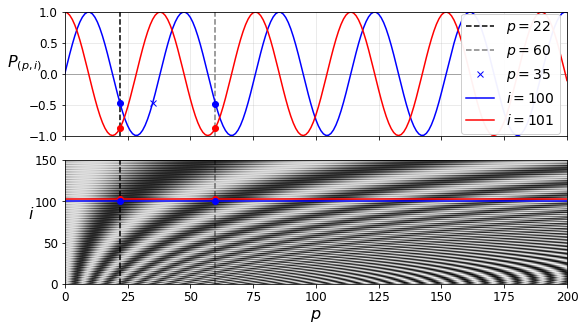

In [83]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [84]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [85]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [86]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [87]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])